In [1]:
import os, sys, time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = 6, 4

sns.set(rc={"figure.figsize": (6, 4)})
sns.set(style="darkgrid")

print("Numpy version:", np.version.version)

# Set working dir to project root
while not os.getcwd().endswith("lmc"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
checkpoint_dir = "resources/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

data_dir = "/home/sergej/data"
os.makedirs(data_dir, exist_ok=True)

### CIFAR10

In [5]:
import torch.nn.functional as F

class MixupCrossEntropyLoss(nn.Module):
    def forward(self, input, target):
        logged_input = F.log_softmax(input, dim=-1)
        loss = -(target * logged_input).sum() / input.shape[0]
        return loss

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.1
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

In [6]:
from src.augmentations import MixupWrapper, CutoutWrapper, CombineWrapper, SmoothOHEWrapper

p = 0.5
train_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=.5, hue=.1)
#     ], p=p),
#     transforms.RandomApply([
#         transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 5))
#     ], p=p),
#     transforms.RandomApply([
#         gauss_noise_tensor
#     ], p=p),
    transforms.RandomApply([
        transforms.RandomRotation((-15, 15), interpolation=transforms.InterpolationMode.BILINEAR)
    ], p=p),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
subset_size = 50 * batch_size

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=train_transform)
trainset, validset = torch.utils.data.random_split(trainset, [45000, 5000],
                                                   generator=torch.Generator().manual_seed(42))
trainset = SmoothOHEWrapper(
    CombineWrapper(
        MixupWrapper(trainset, alpha=0.8, p=0.5),
        CutoutWrapper(trainset, size=10, p=0.5)
    ),
    n_classes=10
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
activation_subset = torch.utils.data.Subset(trainset, list(range(subset_size)))
activation_loader = torch.utils.data.DataLoader(activation_subset, batch_size=batch_size,
                                                shuffle=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

criterion_train = nn.CrossEntropyLoss()  # MixupCrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss()

device = "cuda:0"

Files already downloaded and verified
Files already downloaded and verified


tensor([0.0000, 0.0000, 0.5595, 0.0000, 0.0000, 0.0000, 0.4405, 0.0000, 0.0000,
        0.0000])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


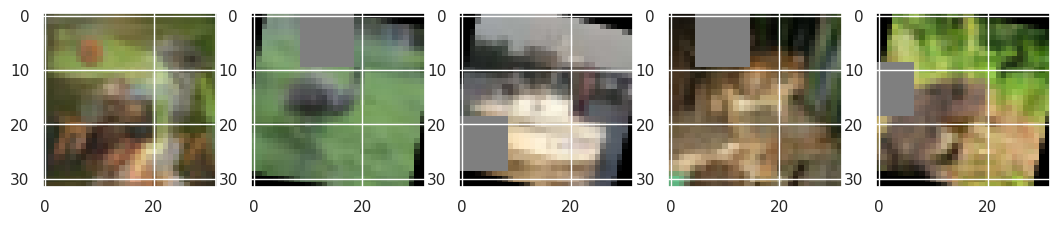

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(13, 4))
for i in range(5):
    img, label = trainset[i]
    print(label)
    axes[i].imshow(np.moveaxis(img.numpy(), 0, -1) / 2 + 0.5)
plt.show()